<a href="https://colab.research.google.com/github/Manjuphoenix/ML_team_buzz/blob/michelle/%20v2_apptom_reasonable_results%20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.image import imread
from collections import Counter

from PIL import Image

import torch
import torchvision
from torch import utils
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, transforms
import torchvision.models as models
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler, ConcatDataset



from sklearn.model_selection import train_test_split
from tqdm import tqdm


torch.cuda.empty_cache()

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

!pip install kaggle

from google.colab import files 
files.upload()

#Make a directory named kaggle and copy the kaggle.json file there; and change its permissions
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#imagenet_data = torchvision.datasets.ImageNet('https://kaggle.com/saroz014/plant-diseases')
#data_loader = torch.utils.data.DataLoader(imagenet_data, batch_size=4, shuffle=True, num_workers=args.nThreads)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


In [7]:
!kaggle datasets download -d manjuphoenix/tomatodataset
!kaggle datasets download -d manjuphoenix/appledataset

tomatodataset.zip: Skipping, found more recently modified local copy (use --force to force download)
 99% 331M/333M [00:17<00:00, 20.8MB/s]
100% 333M/333M [00:17<00:00, 19.7MB/s]


In [5]:
from zipfile import ZipFile
file_name = 'tomatodataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [8]:
from zipfile import ZipFile
file_name = 'appledataset.zip' #the file is your dataset exact name
with ZipFile(file_name, 'r') as zip:
  #zip.printdir()
  print(zip.extractall())
  #zip.close()
  print('Done')

None
Done


In [13]:
!sudo cp -rf /content/Apple/* /content/dataset
!sudo cp -rf /content/Tomato/* /content/dataset

In [21]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomGrayscale(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
])


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# Uncomment the below line based on where you train the model----------------------------------------
# !mkdir /kaggle/working/Tomato

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/test/Tomato* /kaggle/working/Tomato
# !cp -r /kaggle/input/plant-diseases/dataset_itr2/dataset_itr2/train/Tomato* /kaggle/working/Tomato

# !rm -rf /kaggle/working/Tomato/Tomato___Leaf_Mold
# !rm -rf /kaggle/working/Tomato/Tomato___Tomato_mosaic_virus 

# Uncomment this for training on kaggle
# data = datasets.ImageFolder('/kaggle/working/Tomato', transform=transform)----------------------------


# This is for training on Local Machine
data = datasets.ImageFolder('/content/dataset', transform=transform)


# Split into train/test sets:
train_len = int(len(data)*0.7)
train_set, test_set = random_split(data, [train_len, len(data) - train_len])

# Extract classes:
train_classes = [train_set.dataset.targets[i] for i in train_set.indices]
# Calculate support:
class_count = Counter(train_classes)
# Calculate class weights:
class_weights = torch.DoubleTensor([len(train_classes)/c for c in pd.Series(class_count).sort_index().values]) 
# Sampler needs the respective class weight supplied for each image in the dataset:
sample_weights = [class_weights[train_set.dataset.targets[i]] for i in train_set.indices]

sampler = WeightedRandomSampler(weights=sample_weights, num_samples=int(len(train_set)*2), replacement=True)

batch_size=32

# Create torch dataloaders:

dataloaders = DataLoader(data, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The total number of images is:", len(dataloaders))

train_loader = DataLoader(train_set, batch_size=batch_size, sampler=sampler, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a training set is:", len(train_loader)*batch_size)

val_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8]))
print("The number of images in a test set is:", len(val_loader)*batch_size)
print(dataloaders.dataset)

print(data.classes)
# x, y = next(iter(dataloaders[0]))

cuda:0
The total number of images is: 3993
The number of images in a training set is: 127776
The number of images in a test set is: 27392
Dataset ImageFolder
    Number of datapoints: 91256
    Root location: /content/dataset
    StandardTransform
Transform: Compose(
               ToTensor()
               RandomGrayscale(p=0.1)
               RandomHorizontalFlip(p=0.5)
               RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
           )
['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']


In [15]:
import torch
from torchvision.transforms import transforms
from PIL import Image
from pathlib import Path


# # To get the weights from the .pth file!
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.cnn = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)
        self.relu = nn.LeakyReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2)
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=2)
        self.relu2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(32*65*65, 1000)
        self.fc2 = nn.Linear(1000, 8)
        
        
    def forward(self, x):
        out = self.cnn(x)
        out = self.relu(out)
        out = self.maxpool(out)
        out = self.cnn2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = NeuralNetwork()
checkpoint = torch.load(Path('/content/gdrive/MyDrive/v3_tomato.pk1'))
model.load_state_dict(checkpoint)

# # Preprocess any image before passing it to the model
# test_transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.CenterCrop(256),
#     transforms.RandomGrayscale(),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomInvert(),
#     transforms.RandomRotation(30),
# ])


# image = Image.open(Path('/content/gdrive/MyDrive/Tomato_dataset/tHealthy.JPG'))

# input = test_transform(image)

# input = input.view(1, 3, 256,256)

model = model.to(device)

# output = model(input)
# print(output)

# prediction = int(torch.max(output.data, 1)[1].numpy())
# print(prediction)

# if (prediction == 0):
#     print ('Bacterial_spot')
# if (prediction == 1):
#     print ('Early_blight')
# if (prediction == 2):
#     print ('Late_blight')
# if (prediction == 3):
#     print ('Septoria_leaf_spot')
# if (prediction == 4):
#     print ('Two-spotted_spider_mite')
# if (prediction == 5):
#     print ('Target_Spot')
# if (prediction == 6):
#     print ('Tomato_Yellow_Leaf_Curl_Virus')
# if (prediction == 7):
#     print ('Tomato___healthy')

In [ ]:
model.eval()

NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=135200, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=8, bias=True)
)

[[1939   29   26  180   46    4   66   96]
 [  39 1881   56   47  115   32  262   22]
 [ 104  191 1720   59   42   26  157   81]
 [ 237   20   27 1864   25   49  108   37]
 [   0    6    0    0 2460   42    2    0]
 [   2   14    0    7  152 2350    9    0]
 [ 128  342   65   70  125   45 1696    6]
 [  29    8    6   13   20    0    2 2295]]
[81.26571668 76.65036675 72.26890756 78.74947191 98.00796813 92.73875296
 68.46992329 96.71302149]


NeuralNetwork(
  (cnn): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (relu): LeakyReLU(negative_slope=0.01)
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
  (relu2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=135200, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=8, bias=True)
)

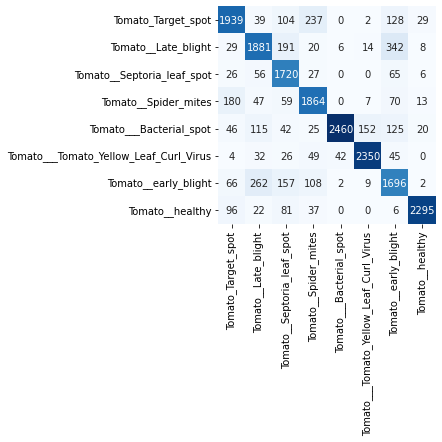

In [20]:
from sklearn.metrics import confusion_matrix

nb_classes = 12

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, xticklabels=data.classes, yticklabels=data.classes, cmap='Blues', fmt='d', cbar=False)
model.eval()

In [22]:
# for param in model.parameters():
#   param.requires_grad = False

model.fc2 = nn.Linear(1000,12)

In [23]:
def train(model,loss_fn,dataloader,optimizer,epoch):
  print('\nEpoch : %d'%epoch)
  
  total_loss=0    
  correct=0
  total=0

  model.train()

  for data in tqdm(dataloader):
    
    inputs,labels=data[0].to(device),data[1].to(device)
    
    outputs=model(inputs)
    
    loss=loss_fn(outputs,labels)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    
    _, predicted = outputs.max(1)
    total += labels.size(0)
    correct += predicted.eq(labels).sum().item()
      
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total
  
  if accuracy >= 95.:
    print('Model trained to 95% accuracy!')
  else:
    accuracies['train'].append(accuracy)
    losses['train'].append(loss)
    print('Train Loss: %.3f | Accuracy: %.3f'%(loss,accuracy))

In [24]:
def test(model,loss_fn,dataloader,epoch):
#   model.eval()

  total_loss=0
  correct=0
  total=0

  with torch.no_grad():
    for data in tqdm(dataloader):
      images,labels=data[0].to(device),data[1].to(device)
      
      outputs=model(images)

      loss= loss_fn(outputs,labels)
      total_loss+=loss.item()
      
      _, predicted = outputs.max(1)
      total += labels.size(0)
      correct += predicted.eq(labels).sum().item()
  
  loss=total_loss/len(dataloader)
  accuracy=100.*correct/total

  losses['val'].append(loss)
  accuracies['val'].append(accuracy)

  print('Test Loss: %.3f | Accuracy: %.3f'%(loss,accuracy)) 

In [27]:
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model.parameters(), lr=0.0003, weight_decay=1e-5, momentum=0.6)

In [28]:
losses = {'train':[], 'val':[]}
accuracies = {'train':[], 'val':[]}
epochs=10
for epoch in range(1,int(epochs)):
  train(model,loss_fn,train_loader,optimizer_ft,epoch)
  test(model,loss_fn,val_loader,epoch)
  


Epoch : 1


100%|██████████| 3993/3993 [12:04<00:00,  5.51it/s]


Train Loss: 0.974 | Accuracy: 68.087


100%|██████████| 856/856 [02:20<00:00,  6.11it/s]


Test Loss: 0.756 | Accuracy: 73.744

Epoch : 2


100%|██████████| 3993/3993 [11:56<00:00,  5.57it/s]


Train Loss: 0.723 | Accuracy: 75.688


100%|██████████| 856/856 [02:20<00:00,  6.08it/s]


Test Loss: 0.678 | Accuracy: 77.149

Epoch : 3


100%|██████████| 3993/3993 [12:07<00:00,  5.49it/s]


Train Loss: 0.666 | Accuracy: 77.472


100%|██████████| 856/856 [02:26<00:00,  5.85it/s]


Test Loss: 0.645 | Accuracy: 78.230

Epoch : 4


100%|██████████| 3993/3993 [12:22<00:00,  5.38it/s]


Train Loss: 0.631 | Accuracy: 78.731


100%|██████████| 856/856 [02:23<00:00,  5.95it/s]


Test Loss: 0.586 | Accuracy: 80.096

Epoch : 5


100%|██████████| 3993/3993 [12:14<00:00,  5.44it/s]


Train Loss: 0.604 | Accuracy: 79.529


100%|██████████| 856/856 [02:21<00:00,  6.03it/s]


Test Loss: 0.578 | Accuracy: 80.235

Epoch : 6


100%|██████████| 3993/3993 [12:15<00:00,  5.43it/s]


Train Loss: 0.579 | Accuracy: 80.334


100%|██████████| 856/856 [02:23<00:00,  5.95it/s]


Test Loss: 0.642 | Accuracy: 77.952

Epoch : 7


100%|██████████| 3993/3993 [12:23<00:00,  5.37it/s]


Train Loss: 0.564 | Accuracy: 80.827


100%|██████████| 856/856 [02:22<00:00,  6.02it/s]


Test Loss: 0.582 | Accuracy: 79.388

Epoch : 8


100%|██████████| 3993/3993 [12:14<00:00,  5.44it/s]


Train Loss: 0.550 | Accuracy: 81.291


100%|██████████| 856/856 [02:26<00:00,  5.85it/s]


Test Loss: 0.552 | Accuracy: 81.134

Epoch : 9


100%|██████████| 3993/3993 [12:15<00:00,  5.43it/s]


Train Loss: 0.534 | Accuracy: 81.913


100%|██████████| 856/856 [02:24<00:00,  5.91it/s]

Test Loss: 0.535 | Accuracy: 81.937


[[1678   71   19   21   28   19   33    1   65    7   22    1]
 [  12 1397   94  122   36  103  101   28    2    1   39   17]
 [   5   51 1720    6   43   50   77   38    0    0   23   14]
 [   0   28    5 1902    1   50   16    1   11    2   19    0]
 [   4   11   28    1 1810   27   61  344    2    1   57   51]
 [   6   36   16  147   20 1716  108   75    9    8  237   13]
 [   6   54  100   40   82  101 1708   94    4    6   90   39]
 [   3    6    8    0  166   20   44 2007    3   12   54   17]
 [  10    7    1   79   26   39    8    7 2275   44   34    0]
 [   6    1    0  119    4   17    2   47   65 2224   43    0]
 [   7   29   24   18  135  306  131  162    5   15 1622    3]
 [   0   13    8   22   61    8    8   33    1    0    1 2276]]
[85.39440204 71.56762295 84.85446473 93.46437346 75.51105549 71.76913425
 73.4939759  85.76923077 89.92094862 87.97468354 66.01546602 93.62402304]


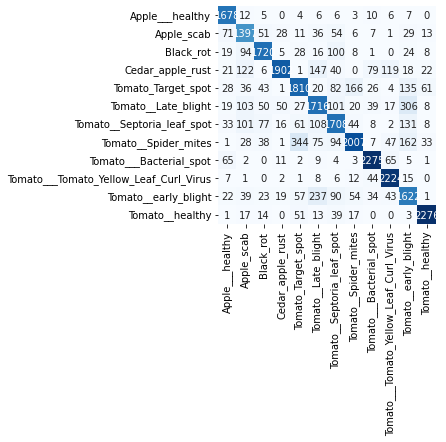

In [30]:
from sklearn.metrics import confusion_matrix

nb_classes = 12

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(val_loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

from sklearn.metrics import confusion_matrix
import seaborn as sns

matrix_confusion = confusion_matrix(predlist, lbllist)
sns.heatmap(matrix_confusion, square=True, annot=True, xticklabels=data.classes, yticklabels=data.classes, cmap='Blues', fmt='d', cbar=False)

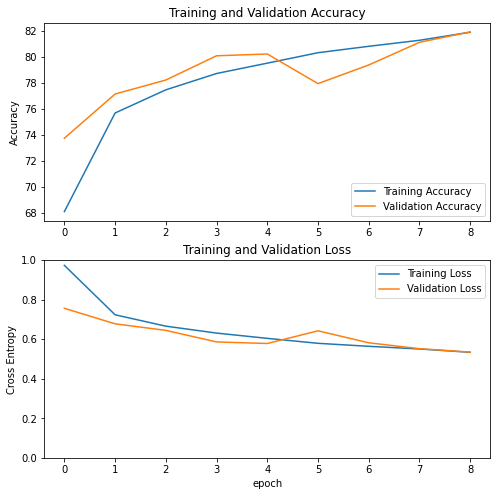

In [31]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(accuracies['train'], label='Training Accuracy')
plt.plot(accuracies['val'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
# plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(losses['train'], label='Training Loss')
plt.plot(losses['val'], label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [32]:


#Testing classification accuracy for individual classes.
classes = ['Apple___healthy', 'Apple_scab', 'Black_rot', 'Cedar_apple_rust', 'Tomato_Target_spot', 'Tomato__Late_blight', 'Tomato__Septoria_leaf_spot', 'Tomato__Spider_mites', 'Tomato___Bacterial_spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato__early_blight', 'Tomato__healthy']
class_correct = list(0. for i in range(12))
class_total = list(0. for i in range(12))
c = []
with torch.no_grad():
    for data in val_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted==labels).squeeze()
        # print(c)
        for i in range(12):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1
print(c.type())
for i in range(12):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))



torch.cuda.BoolTensor
Accuracy of Apple___healthy : 85 %
Accuracy of Apple_scab : 72 %
Accuracy of Black_rot : 84 %
Accuracy of Cedar_apple_rust : 93 %
Accuracy of Tomato_Target_spot : 78 %
Accuracy of Tomato__Late_blight : 74 %
Accuracy of Tomato__Septoria_leaf_spot : 73 %
Accuracy of Tomato__Spider_mites : 84 %
Accuracy of Tomato___Bacterial_spot : 90 %
Accuracy of Tomato___Tomato_Yellow_Leaf_Curl_Virus : 86 %
Accuracy of Tomato__early_blight : 64 %
Accuracy of Tomato__healthy : 94 %


In [33]:
avg = 0
for i in range(8):
  temp = (100 * class_correct[i] / class_total[i])
  avg = avg + temp
avg = avg/8
print('Average accuracy = ', avg)

Average accuracy =  81.0547720778889


In [34]:
torch.save(model.state_dict(), '/content/gdrive/MyDrive/v2_apptom.pk1')
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('/content/gdrive/MyDrive/v2_apptom.pt')